In [1]:
# imports 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from collections import Counter

# read data
folder = '../input/oxford-flower-segmentations/'

mat = scipy.io.loadmat(folder + 'imagelabels.mat')

labels = mat['labels'].flatten()

class_occurances = Counter(labels)

## Classes Distribution

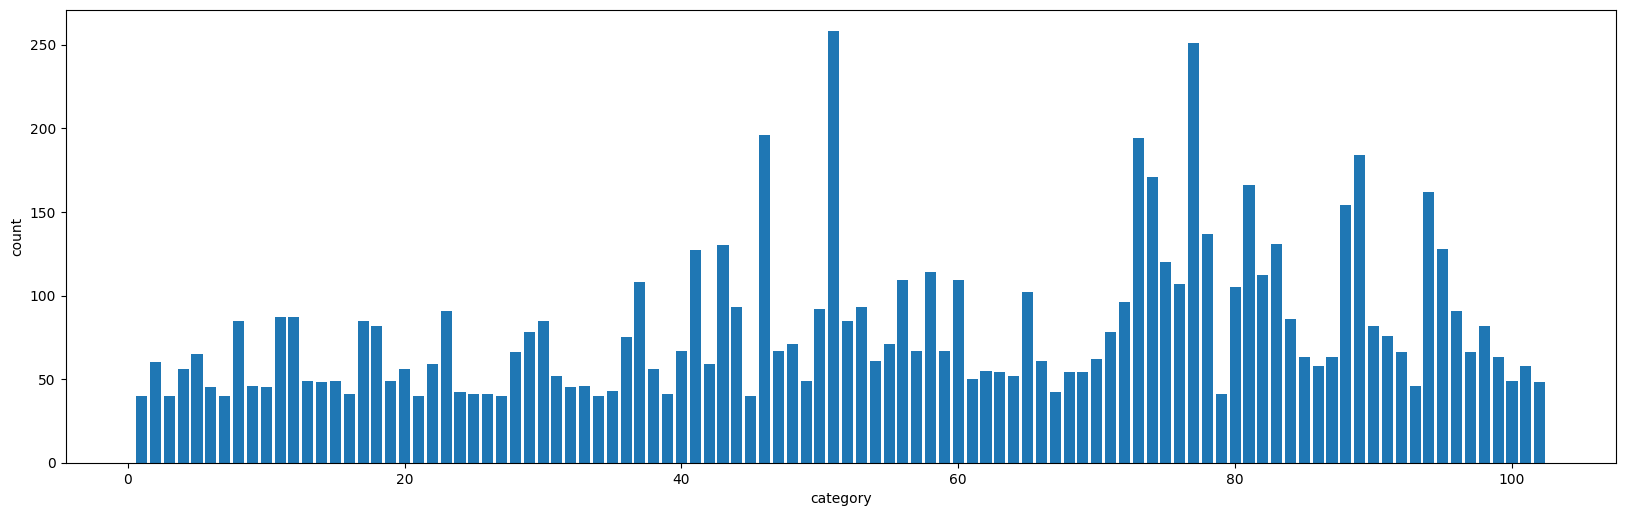

In [2]:
plt.figure(figsize=(20, 6), dpi=100)
plt.bar(class_occurances.keys(),class_occurances.values())
plt.xlabel('category')
plt.ylabel('count')
plt.show()

## Data Augmentation

the data is imbalanced so we will use image augmenatiotn in order to create more observations for the classes with the smallest amount of data.

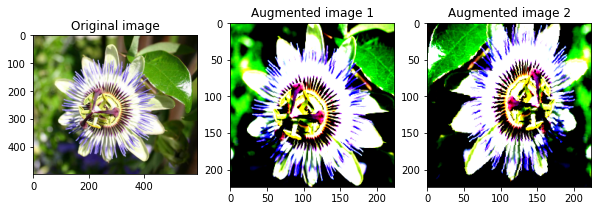

In [3]:
from torchvision import transforms
from PIL import Image

def visualize(original, augmented1, augmented2):
    fig = plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.subplot(1,3,2)
    plt.title('Augmented image 1')
    plt.imshow(augmented1.permute(1, 2, 0))
    plt.subplot(1,3,3)
    plt.title('Augmented image 2')
    plt.imshow(augmented2.permute(1, 2, 0))
    
    
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image = Image.open(folder + 'jpg/jpg/image_00001.jpg')
augmented_image1 = image_transforms['train'](image)
augmented_image2 = image_transforms['train'](image)

visualize(image, augmented_image1, augmented_image2)

## Load data

In [4]:
from sklearn.model_selection import train_test_split
import shutil
import pathlib

X = range(1, len(labels) + 1)

# train 0.4 test 0.3 validation 0.3
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, labels, test_size=0.6)
X_test1, X_val1, y_test1, y_val1 = train_test_split(X_test1, y_test1, test_size=0.5)

# train 0.55 test 0.3 validation 0.15
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, labels, test_size=0.45)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test2, y_test2, test_size=1/3)

def create_img_name(img_idx):
    return 'image_' + f'{img_idx:05d}' + '.jpg'

def create_data_folder(idxs, ys, filename):
    if os.path.exists(filename):
         shutil.rmtree(filename)
    
    for i in range(1, 103):
        pathlib.Path(filename + '/' + str(i)).mkdir(parents=True, exist_ok=True) 

    for idx, y in zip(idxs, ys):
        shutil.copy(folder + 'jpg/jpg/' + create_img_name(idx), filename + '/' + str(y))

# first split
create_data_folder(X_train1, y_train1, '../training1_0.4')
create_data_folder(X_test1, y_test1, '../testing1_0.3')
create_data_folder(X_val1, y_val1, '../validation1_0.3')

# second split
create_data_folder(X_train2, y_train2, '../training2_0.55')
create_data_folder(X_test2, y_test2, '../testing2_0.3')
create_data_folder(X_val2, y_val2, '../validation2_0.15')


## Balancing Training Data

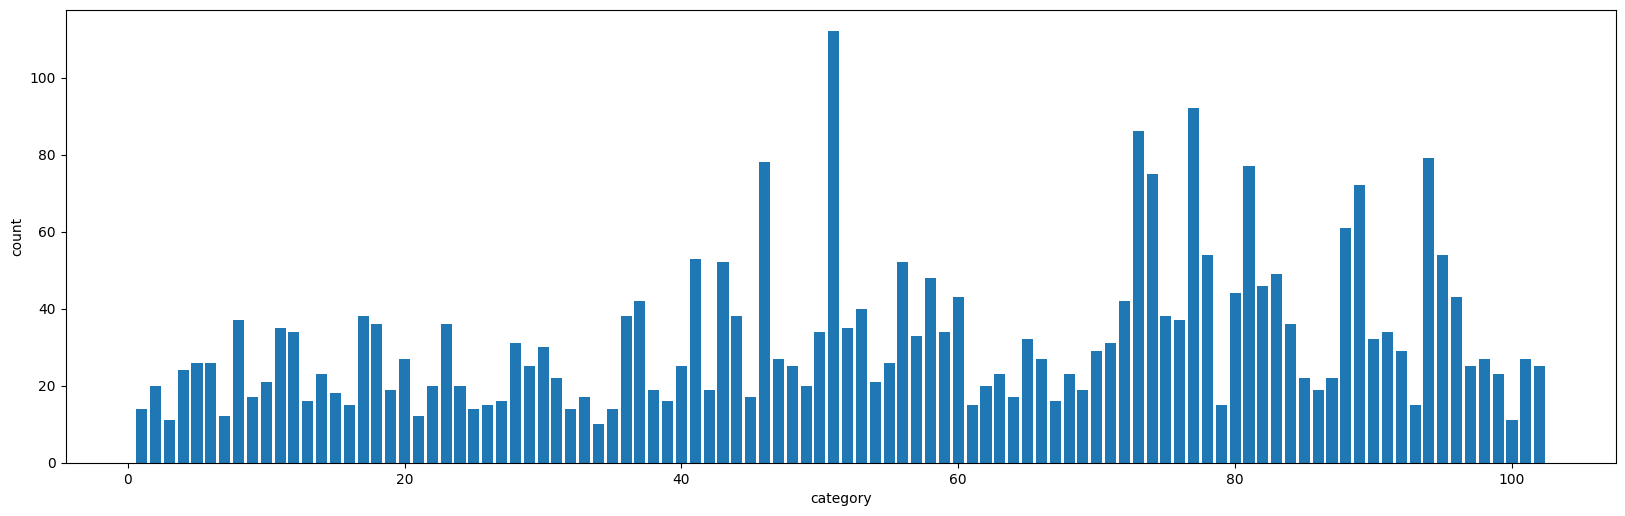

In [5]:
# count classes occurances

occ = {}
for i in range(1, 103):
    DIR = '../training1_0.4/' + str(i)
    occ[i] = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])

plt.figure(figsize=(20, 6), dpi=100)
plt.bar(occ.keys(),occ.values())
plt.xlabel('category')
plt.ylabel('count')
plt.show()

In [6]:
# unloader = transforms.ToPILImage()

# def tensor_to_PIL(tensor):
#     image = tensor.cpu().clone()
#     image = image.squeeze(0)
#     image = unloader(image)
#     return image


# max_amount = max(occ.keys()) # get the maximum occurances of class
# max_amount = min(max_amount, 30)

# # data balancing
# def data_balancer(main_dir, tranform_func):
#     for i in range(1, 103):
#         DIR = main_dir + str(i)
#         amount = occ[i]
#         index = 0

#         while amount < max_amount:
#             for filename in os.listdir(DIR):
#                 if amount < max_amount:

#                     image = Image.open(DIR + '/' + filename)
#                     augmented_image = tranform_func(image)
#                     augmented_image = tensor_to_PIL(augmented_image)
#                     augmented_image.save(DIR + f'/augmented{index}_' + filename)

#                     amount +=1
#                     index += 1
                    
# data_balancer('../training1_0.4/', image_transforms['test'])
# data_balancer('../testing1_0.3/', image_transforms['test'])
# data_balancer('../validation1_0.3/', image_transforms['test'])

# # data_balancer('../training2_0.55/', image_transforms['test'])
# # data_balancer('../testing2_0.3/', image_transforms['test'])
# # data_balancer('../validation2_0.15/', image_transforms['test'])
                
# occ = {}
# for i in range(1, 103):
#     DIR = '../training1_0.4/' + str(i)
#     occ[i] = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])

# plt.figure(figsize=(20, 6), dpi=100)
# plt.bar(occ.keys(),occ.values())
# plt.xlabel('category')
# plt.ylabel('count')
# plt.show()

## Data Loaders

In [7]:
from torchvision import datasets
from torch.utils.data import DataLoader


batch_size = 32

data1 = {
    'train':
    datasets.ImageFolder(root='../training1_0.4', transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root='../validation1_0.3', transform=image_transforms['test']),
    'test':
    datasets.ImageFolder(root='../testing1_0.3', transform=image_transforms['test'])
}

dataloaders1 = {
    'train': DataLoader(data1['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data1['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data1['test'], batch_size=batch_size, shuffle=True)
}

data2 = {
    'train':
    datasets.ImageFolder(root='../training2_0.55', transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root='../validation2_0.15', transform=image_transforms['test']),
    'test':
    datasets.ImageFolder(root='../testing2_0.3', transform=image_transforms['test'])
}

dataloaders2 = {
    'train': DataLoader(data2['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data2['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data2['test'], batch_size=batch_size, shuffle=True)
}

## First Model - VGG16

In [8]:
import torch
from torch import nn, optim, cuda
from torch import nn
from torch import optim
import torchvision.models as models

on_gpu = cuda.is_available()
print(f'gpu enabled: {on_gpu}')

def get_pretrained_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 102), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 102), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if on_gpu:
        model = model.to('cuda')

    return model




gpu enabled: True


In [9]:
# copyrights - https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

import copy
from timeit import default_timer as timer

on_gpu = True

def evaluate(model):
    model.to('cuda')

    with torch.no_grad():
        accurately_identified = 0
        total_tested = 0
        for inputs, labels in dataloaders1['test']:
            inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
            model.to('cuda')
            output = model(inputs)
            _, predicted = torch.max(output.data, 1)
            total_tested += labels.size(0)
            accurately_identified += (predicted == labels).sum().item()

    print("The accuracy of network is : {}".format(accurately_identified/total_tested))

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          n_epochs=15,
          print_every=1):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            if on_gpu:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()

                for data, target in valid_loader:
                    if on_gpu:
                        data, target = data.cuda(), target.cuda()

                    output = model(data)

                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                    print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                else:
                    epochs_no_improve += 1


    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.')

    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    # loss graph
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(
            history[c], label=c)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log Likelihood')
    plt.title('Training and Validation Losses')
    
    # accuracy graph 
    plt.figure(figsize=(8, 6))
    for c in ['train_acc', 'valid_acc']:
        plt.plot(
            100 * history[c], label=c)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    return model, history



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Starting Training from Scratch.

Epoch: 0	100.00% complete. 52.40 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 3.1883 	Validation Loss: 1.8458
		Training Accuracy: 30.05%	 Validation Accuracy: 55.27%
Epoch: 1	100.00% complete. 50.33 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.6270 	Validation Loss: 1.3261
		Training Accuracy: 57.16%	 Validation Accuracy: 65.40%
Epoch: 2	100.00% complete. 50.26 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.2705 	Validation Loss: 1.1197
		Training Accuracy: 65.25%	 Validation Accuracy: 69.52%
Epoch: 3	100.00% complete. 50.63 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.1347 	Validation Loss: 0.9646
		Training Accuracy: 68.70%	 Validation Accuracy: 73.99%
Epoch: 4	100.00% complete. 49.77 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.9444 	Validation Loss: 0.9011
		Training Accuracy: 73.01%	 Validation Accuracy: 76.07%
Epoch: 5	100.00% complete. 50.17 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.9172 	Validation

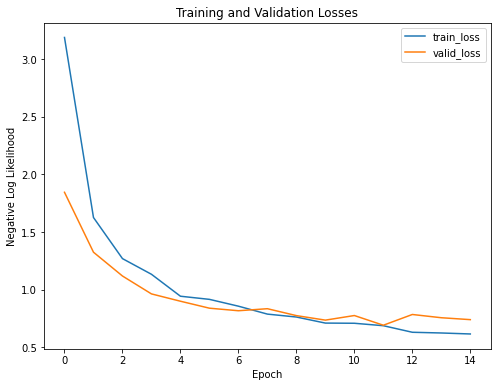

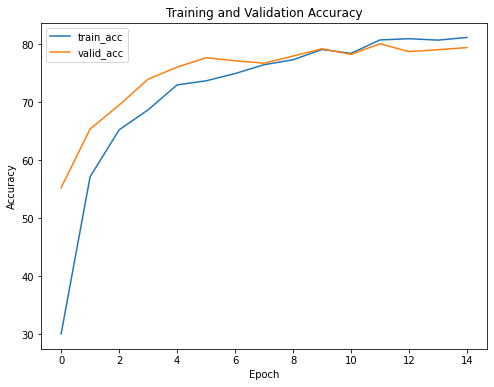

In [10]:
vgg_model = get_pretrained_model('vgg16')

criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg_model.parameters())

model, history = train(
    vgg_model,
    criterion,
    optimizer,
    dataloaders1['train'],
    dataloaders1['val'],
    save_file_name='vgg16_1.h')

evaluate(model)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 67.79 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 2.8452 	Validation Loss: 1.4143
		Training Accuracy: 34.91%	 Validation Accuracy: 66.88%
Epoch: 1	100.00% complete. 68.27 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.4551 	Validation Loss: 1.0428
		Training Accuracy: 60.00%	 Validation Accuracy: 74.13%
Epoch: 2	100.00% complete. 68.27 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.1409 	Validation Loss: 0.9500
		Training Accuracy: 68.29%	 Validation Accuracy: 75.83%
Epoch: 3	100.00% complete. 68.44 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.0344 	Validation Loss: 0.7911
		Training Accuracy: 70.58%	 Validation Accuracy: 80.31%
Epoch: 4	100.00% complete. 68.29 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.9008 	Validation Loss: 0.7684
		Training Accuracy: 73.77%	 Validation Accuracy: 81.20%
Epoch: 5	100.00% complete. 68.30 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.8813 	Validation

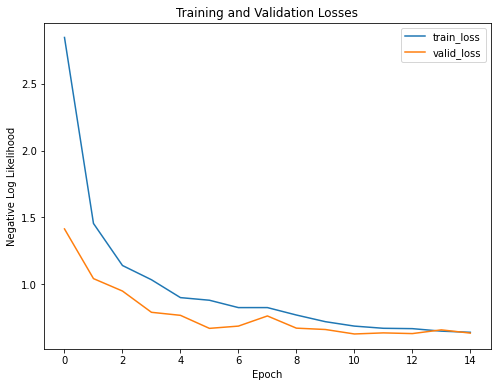

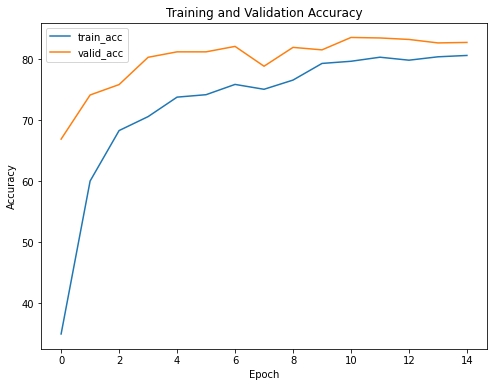

In [15]:
vgg_model = get_pretrained_model('vgg16')
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg_model.parameters())

model2, history = train(
    vgg_model,
    criterion,
    optimizer,
    dataloaders2['train'],
    dataloaders2['val'],
    save_file_name='vgg16_2.h')

evaluate(model2)

## Second Model - ResNet50

Epoch: 0	100.00% complete. 41.60 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 3.8513 	Validation Loss: 2.9050
		Training Accuracy: 18.87%	 Validation Accuracy: 35.08%
Epoch: 1	100.00% complete. 42.47 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.2656 	Validation Loss: 1.6474
		Training Accuracy: 48.43%	 Validation Accuracy: 63.09%
Epoch: 2	100.00% complete. 42.12 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.4858 	Validation Loss: 1.2135
		Training Accuracy: 63.54%	 Validation Accuracy: 69.52%
Epoch: 3	100.00% complete. 41.87 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.1636 	Validation Loss: 0.9622
		Training Accuracy: 69.50%	 Validation Accuracy: 74.93%
Epoch: 4	100.00% complete. 41.29 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.9257 	Validation Loss: 0.7914
		Training Accuracy: 75.48%	 Validation Accuracy: 79.04%
Epoch: 5	100.00% complete. 41.62 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.8032 	Validation Loss: 0.7301
		Training Accuracy

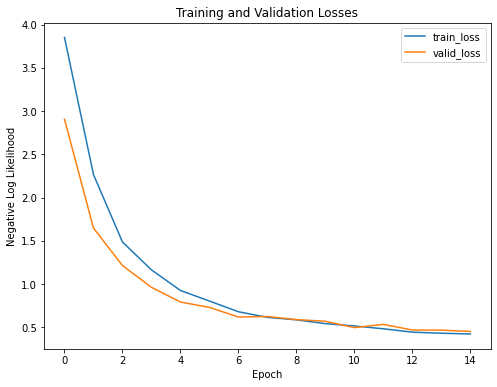

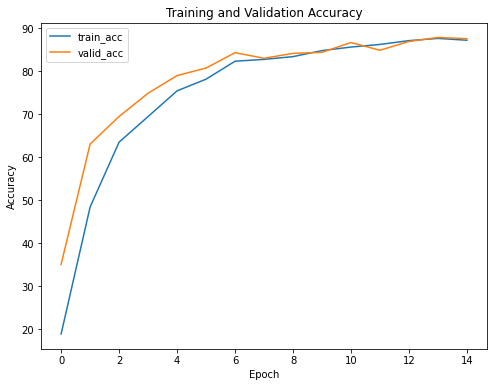

In [13]:
resnet_model = get_pretrained_model('resnet50')
criterion = nn.NLLLoss()
optimizer = optim.Adam(resnet_model.parameters())

model, history = train(
    resnet_model,
    criterion,
    optimizer,
    dataloaders1['train'],
    dataloaders1['val'],
    save_file_name='resnet50_1.h')

evaluate(model)




Starting Training from Scratch.

Epoch: 0	100.00% complete. 58.05 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 3.5426 	Validation Loss: 2.1749
		Training Accuracy: 24.49%	 Validation Accuracy: 58.42%
Epoch: 1	100.00% complete. 56.48 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.8298 	Validation Loss: 1.1490
		Training Accuracy: 56.36%	 Validation Accuracy: 72.09%
Epoch: 3	100.00% complete. 56.44 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.9209 	Validation Loss: 0.6969
		Training Accuracy: 75.42%	 Validation Accuracy: 83.16%
Epoch: 4	100.00% complete. 56.63 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.7851 	Validation Loss: 0.5744
		Training Accuracy: 78.44%	 Validation Accuracy: 86.33%
Epoch: 5	100.00% complete. 56.11 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6950 	Validation Loss: 0.5474
		Training Accuracy: 80.95%	 Validation Accuracy: 86.49%
Epoch: 6	100.00% complete. 57.15 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.6017 	Validation

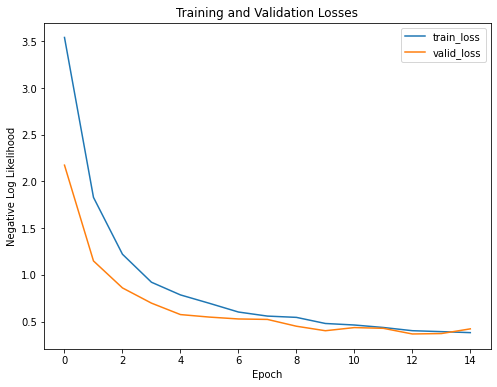

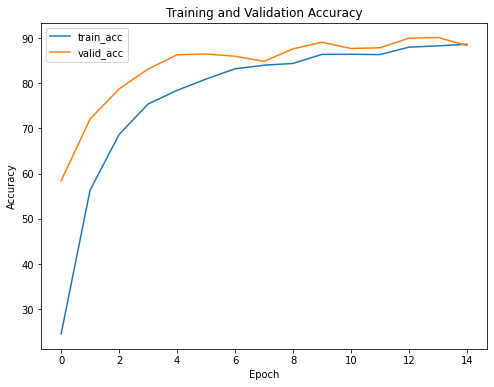

In [14]:
resnet_model = get_pretrained_model('resnet50')
criterion = nn.NLLLoss()
optimizer = optim.Adam(resnet_model.parameters())

model, history = train(
    resnet_model,
    criterion,
    optimizer,
    dataloaders2['train'],
    dataloaders2['val'],
    save_file_name='resnet50_2.h')

evaluate(model)